In [1]:
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt
import pinocchio as pin
from pinocchio.utils import rotate
from robot_descriptions.loaders.pinocchio import load_robot_description
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
import pink
from pink import solve_ik
from pink.tasks import FrameTask
import qpsolvers
import time
from tqdm import tqdm



from scripts.humanoid_mpc import MPCRobust, feet, foot, MPCForce
from scripts.simulation_utils import compute_initial_position, draw_feet_footprints

## Import robot

In [2]:
robot = load_robot_description(
        "jvrc_description", root_joint=pin.JointModelFreeFlyer()
    )
configuration = pink.Configuration(robot.model, robot.data, robot.q0)
viz = MeshcatVisualizer(robot)
q0 = configuration.q.copy()
viz.display(q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


# Parameters

In [3]:
# Robot parameters
leg_length = 0.75
x_left_foot = 0.096
x_right_foot = - 0.096 
h_ankle = 0.076
#    Estimated robot parameters
h_CoM = leg_length + h_ankle 
foot_length = (leg_length + h_ankle) * 0.28
foot_width = foot_length / 2

# Step Parameters
T = 0.025            # Sample period
N = 50             # Iteration Window
step_duration = 3  # Step duration
overlap = 50       # Samples in overlap region after each step
duration = 30        # Total walking duration
step_spread_y = foot_length * 0.7 


compute_initial_position(configuration, h_CoM, T)
viz.display(configuration.q)

## Compute MPC

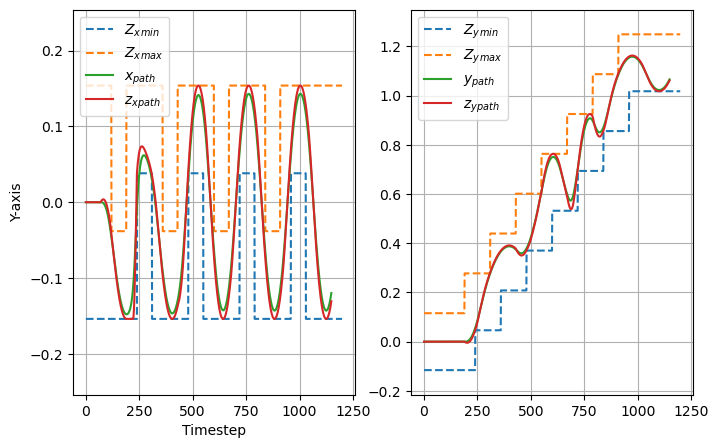

In [4]:
g = 9.81

robot_feet = feet(spread=step_spread_y,
                  length=foot_length,
                  width=foot_width,
                  right=foot(x_right_foot, 0),
                  left=foot(x_left_foot, 0))
mpc = MPCRobust(T, N, h_CoM, g, robot_feet, 
                duration=duration, 
                step_duration=step_duration,
                overlap=overlap, 
                )

Zxmin, Zxmax = mpc.Zmin[0], mpc.Zmax[0]
x_path, zx_path, jerks = mpc.solve(Zxmin, Zxmax, coord='x')

Zymin, Zymax = mpc.Zmin[1], mpc.Zmax[1]
y_path, zy_path, jerks = mpc.solve(Zymin, Zymax, coord='y')

feet_tracker = mpc.feet_tracker
n_steps = int(step_duration // T)

fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].plot(Zxmin,'--', label= r'${Z_x}_{min}$')
ax[0].plot(Zxmax,'--', label=r"${Z_x}_{max}$")
ax[0].plot(x_path, label=r"$x_{path}$")
ax[0].plot(zx_path, label=r"${z_x}_{path}$")
ax[0].set_xlabel('Timestep')
ax[0].set_ylabel('X-axis')
min_yaxis, max_yaxis = min(Zxmin)-0.1, max(Zxmax)+0.1
ax[0].set_ylim(min_yaxis, max_yaxis)
ax[0].grid()
ax[0].legend()

ax[1].plot(Zymin,'--', label= r'${Z_y}_{min}$')
ax[1].plot(Zymax,'--', label=r"${Z_y}_{max}$")
ax[1].plot(y_path, label=r"$y_{path}$")
ax[1].plot(zy_path, label=r"${z_y}_{path}$")
ax[0].set_xlabel('Timestep')
ax[0].set_ylabel('Y-axis')
ax[1].set_ylim(min(Zymin)-0.1, max(Zymax)+0.1)
ax[1].grid()
plt.legend()



## MPC Control

In [5]:
draw_feet_footprints(mpc.right_trajectory, 'right', foot_length, foot_width, viz)
draw_feet_footprints(mpc.left_trajectory, 'left', foot_length, foot_width, viz)

### Reset position:

In [6]:
configuration = pink.Configuration(robot.model, robot.data, robot.q0)
compute_initial_position(configuration, leg_length + h_ankle,T)
viz.display(configuration.q)

## Simulation 1:

In [7]:
root_task = FrameTask("root_joint", position_cost=1.0, orientation_cost=1.0)

left_ankle_task = FrameTask("l_ankle", position_cost=1.0, orientation_cost=1.0)
right_ankle_task = FrameTask("r_ankle", position_cost=1.0, orientation_cost=1.0)

n_steps = step_duration // T
last_left_y = 0
last_right_y = 0
step = 0
for i in tqdm(range(len(x_path))):

    root_pose = configuration.get_transform_frame_to_world("root_joint").copy()
    root_pose.translation[0] = -x_path[i]
    root_pose.translation[1] = y_path[i]
    root_task.set_target(root_pose)
     
    left_foot, right_foot = feet_tracker[i]
    
    z_x = zx_path[i]
    z_y = zy_path[i]
    left_foot_pose = configuration.get_transform_frame_to_world("l_ankle").copy()
    right_foot_pose = configuration.get_transform_frame_to_world("r_ankle").copy()
    
    
    left_foot_pose.translation[2] = h_ankle
    right_foot_pose.translation[2] = h_ankle

    if left_foot and not right_foot:
        left_foot_pose.translation[1] = z_y
    if not left_foot and right_foot:
        right_foot_pose.translation[1] = z_y
    if left_foot and right_foot:
        left_foot_pose.translation[1] = z_y
        right_foot_pose.translation[1] = z_y
        
    left_ankle_task.set_target(left_foot_pose)
    right_ankle_task.set_target(right_foot_pose)
    if i % n_steps == 0:
        print('New step')

    velocity = solve_ik(configuration, [root_task, left_ankle_task, right_ankle_task], T, solver='daqp')
    configuration.integrate_inplace(velocity, T)
    viz.display(configuration.q)
    time.sleep(T)


  0%|          | 0/1150 [00:00<?, ?it/s]

New step


 10%|█         | 120/1150 [00:10<01:29, 11.50it/s]

New step


 21%|██        | 240/1150 [00:21<01:26, 10.50it/s]

New step


 31%|███       | 358/1150 [00:32<01:06, 11.94it/s]

New step


 42%|████▏     | 478/1150 [00:43<00:58, 11.53it/s]

New step


 52%|█████▏    | 596/1150 [00:54<00:48, 11.39it/s]

New step


 62%|██████▏   | 716/1150 [01:04<00:37, 11.54it/s]

New step


 73%|███████▎  | 834/1150 [01:15<00:25, 12.28it/s]

New step


 83%|████████▎ | 954/1150 [01:26<00:17, 11.02it/s]

New step


 93%|█████████▎| 1072/1150 [01:37<00:07, 10.72it/s]

New step


100%|██████████| 1150/1150 [01:45<00:00, 10.95it/s]


# Simulation 2:

Not working properly. Trying to lower the pelvis to get more stability

In [6]:
root_task = FrameTask("root_joint", position_cost=1.0, orientation_cost=1.0)
pelvis_task = FrameTask("PELVIS_S", position_cost=1.0, orientation_cost=0.0)
left_ankle_task = FrameTask("l_ankle", position_cost=1.0, orientation_cost=1.0)
right_ankle_task = FrameTask("r_ankle", position_cost=1.0, orientation_cost=1.0)

n_steps = step_duration // T
last_left_y = 0
last_right_y = 0
step = 0
for i in tqdm(range(len(x_path))):

    root_pose = configuration.get_transform_frame_to_world("root_joint").copy()
    root_pose.translation[0] = -x_path[i]
    root_pose.translation[1] = y_path[i]
    root_task.set_target(root_pose)

    pelvis_pose = configuration.get_transform_frame_to_world("PELVIS_S").copy()
    pelvis_pose.translation[2] = 0.4
    pelvis_task.set_target(pelvis_pose)
    
    left_foot, right_foot = feet_tracker[i]
    z_x = zx_path[i]
    z_y = zy_path[i]
    left_foot_pose = configuration.get_transform_frame_to_world("l_ankle").copy()
    right_foot_pose = configuration.get_transform_frame_to_world("r_ankle").copy()
    
    
    left_foot_pose.translation[2] = h_ankle
    right_foot_pose.translation[2] = h_ankle

    if left_foot and not right_foot:
        left_foot_pose.translation[1] = z_y
    if not left_foot and right_foot:
        right_foot_pose.translation[1] = z_y
    if left_foot and right_foot:
        left_foot_pose.translation[1] = z_y
        right_foot_pose.translation[1] = z_y
        
    left_ankle_task.set_target(left_foot_pose)
    right_ankle_task.set_target(right_foot_pose)
    if i % n_steps == 0:
        print('New step')

    velocity = solve_ik(configuration, [root_task, pelvis_task, left_ankle_task, right_ankle_task], T, solver='daqp')
    configuration.integrate_inplace(velocity, T)
    viz.display(configuration.q)
    time.sleep(T)


  0%|          | 1/1150 [00:00<02:15,  8.47it/s]

New step


 10%|█         | 120/1150 [00:12<01:36, 10.62it/s]

New step


 17%|█▋        | 195/1150 [00:19<01:37,  9.83it/s]


NotWithinConfigurationLimits: Joint 11 violates configuration limits -0.785398163397 <= -0.7854009286614948 <= 0.610865238198